## 5. Practices
Hãy thử làm mọi cách để f1_score trên tập test đạt >= 85%
- Thử thay bằng model có độ phức tạp hơn ( Có dropout, Batch_Norm )
- Dùng optimizer khác, scheduler khác
- Thử tăng hoặc giảm Learning rate, Batch_size
- Thử dùng [Lion Optimizer](https://github.com/lucidrains/lion-pytorch)
```python
!pip install lion-pytorch
from lion_pytorch import Lion
opt = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)
```



- Question: ý nghĩa của lớp **AdaptiveAvgPool2d**

https://pytorch.org/docs/stable/nn.html

- THử dùng augment data
- Chạy earlystoping cho f1

## 1. EDA bộ dataset

- Hiển thị được phân phối class của tập train/test
- Thông kê được tổng số dữ liệu, tổng số class

In [1]:
# !pip install lion-pytorch

In [2]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import torch.optim as optim
from glob import glob
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
import os

In [3]:
from lion_pytorch import Lion

In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Đường dẫn tới các thư mục chứa dữ liệu train và test trên máy của bạn
train_dir = 'DATA\Train'
test_dir = 'DATA\Test'

# Chuẩn bị transform
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Tải dữ liệu từ các thư mục trên máy của bạn
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

# Số lượng các lớp
num_classes = len(train_data.classes)
# Tên của các lớp
classes_name = train_data.classes
# classes2idx: ánh xạ từ tên lớp sang chỉ số (index)
classes2idx = train_data.class_to_idx
print(f"Số lượng lớp: {num_classes}")
print(f"Tên lớp: {classes_name}")
print(f"Ánh xạ từ tên lớp sang chỉ số: {classes2idx}")
print("Number of train: ", len(train_data))
print("Number of test: ", len(test_data))


Số lượng lớp: 2
Tên lớp: ['Normal', 'Sleepy']
Ánh xạ từ tên lớp sang chỉ số: {'Normal': 0, 'Sleepy': 1}
Number of train:  13859
Number of test:  404


In [5]:
train_data

Dataset ImageFolder
    Number of datapoints: 13859
    Root location: DATA\Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

run: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 40.91it/s]


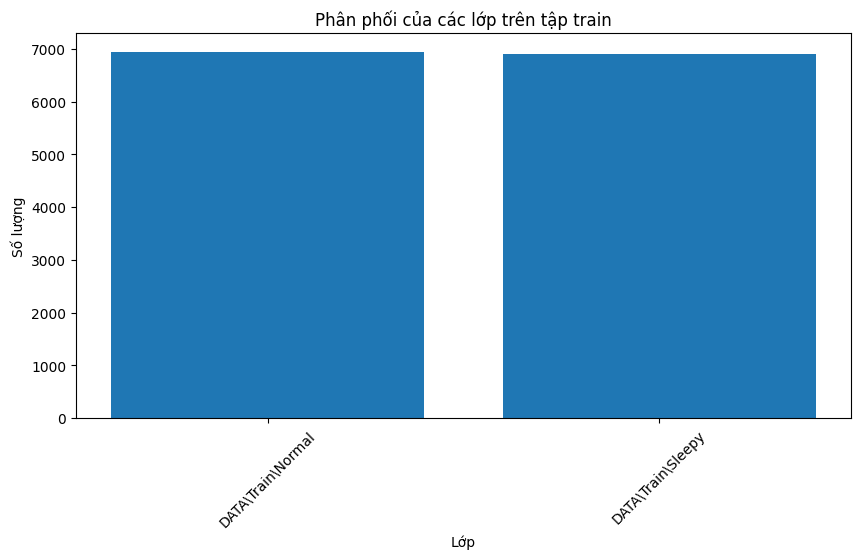

In [6]:
# Phân phối của các lớp trên tập train
all_class = glob("DATA\Train\*")
train_class_counts =  {}
for folder_class in tqdm(all_class, desc='run'):
    name = folder_class.split('/')[-1]
    train_class_counts[name] = len(glob(f"{folder_class}/*"))
train_class_counts = dict(sorted(train_class_counts.items(), key=lambda item: item[0]))

plt.figure(figsize=(10, 5))
plt.bar(list(train_class_counts.keys()), list(train_class_counts.values()))
plt.title('Phân phối của các lớp trên tập train')
plt.xlabel('Lớp')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)
plt.show()

run: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1000.91it/s]


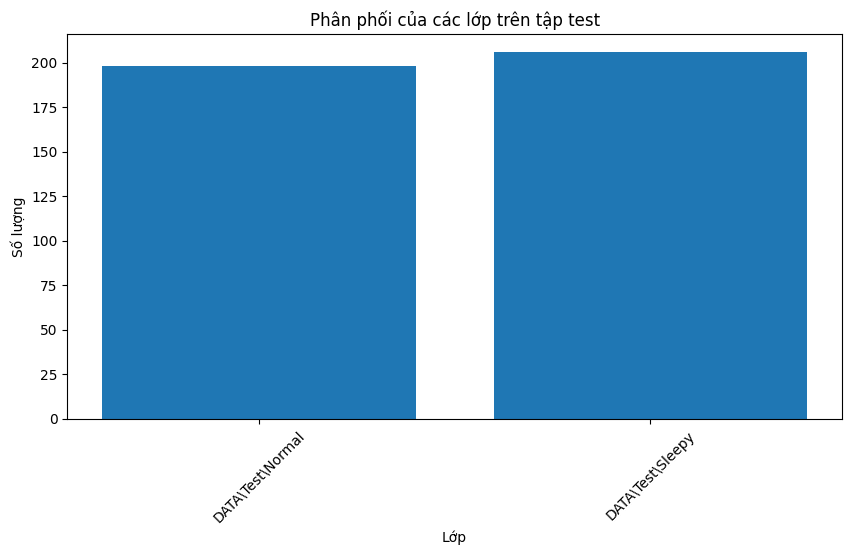

In [7]:
# Phân phối của các lớp trên tập test
all_test_classes = glob("DATA\Test\*")
test_class_counts = {}
for folder_class in tqdm(all_test_classes, desc='run'):
    name = folder_class.split('/')[-1]
    test_class_counts[name] = len(glob(f"{folder_class}/*"))

# Sort dict by key
test_class_counts = dict(sorted(test_class_counts.items(), key=lambda item: item[0]))

# Hiển thị đồ thị phân phối tập test
plt.figure(figsize=(10, 5))
plt.bar(list(test_class_counts.keys()), list(test_class_counts.values()))
plt.title('Phân phối của các lớp trên tập test')
plt.xlabel('Lớp')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)
plt.show()

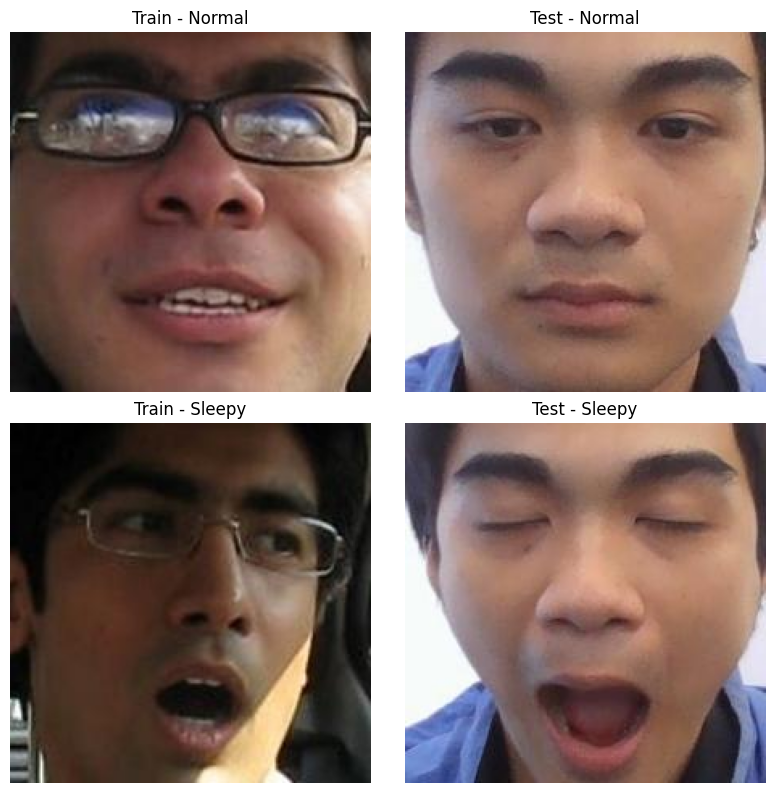

In [8]:
# Khởi tạo kích thước của figure
num_rows = len(classes_name)
num_cols = 3
plt.figure(figsize=(num_cols * 4, num_rows * 4))

# Vòng lặp để vẽ hình
for idx, c in enumerate(classes_name, start=1):
    # Lấy ngẫu nhiên một hình từ thư mục train và test
    path_test_image = random.choice(list(glob(f"DATA/Test/{c}/*")))
    path_train_image = random.choice(list(glob(f"DATA/Train/{c}/*")))

    # Thêm subplot cho cặp hình
    plt.subplot(num_rows, num_cols, idx * num_cols - 2)
    plt.imshow(plt.imread(path_train_image))
    plt.title(f"Train - {c}")
    plt.axis("off")

    plt.subplot(num_rows, num_cols, idx * num_cols - 1)
    plt.imshow(plt.imread(path_test_image))
    plt.title(f"Test - {c}")
    plt.axis("off")

# Hiển thị đồ thị
plt.tight_layout()
plt.show()




# 2. Modeling

In [9]:
import torch
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn

#### Define models CNNs basic

In [10]:
# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes = 10):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, 3)
#         self.pool1 = nn.MaxPool2d(2, 2)  # Max pooling layer 1
#         self.bn1   = nn.BatchNorm2d(16)
        
#         self.conv2 = nn.Conv2d(16, 32, 3)
#         self.pool2 = nn.MaxPool2d(2, 2)  # Max pooling layer 2
#         self.bn2   = nn.BatchNorm2d

        
#         self.avgpool = nn.AdaptiveAvgPool2d((16, 16))
#         self.fc1 = nn.Linear(32*16*16, 256)
#         self.fc2 = nn.Linear(256, num_classes)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = nn.functional.relu(x)
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = nn.functional.relu(x)
#         x = self.pool2(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc1(x)
#         x = nn.functional.relu(x)
#         x = self.fc2(x)
#         return x

In [11]:
# import torch
# model = SimpleCNN()
# random_image = torch.rand(1, 3, 256, 256)
# model(random_image).shape

In [12]:
# import torch
# model = SimpleCNN()
# random_image = torch.rand(1, 3, 448, 448)
# model(random_image).shape

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes = 2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)  # Max pooling layer 1
        self.bn1   = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)  # Max pooling layer 2
        self.bn2   = nn.BatchNorm2d

        
        self.avgpool = nn.AdaptiveAvgPool2d((16, 16))
        self.fc1 = nn.Linear(32*16*16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

In [14]:
## Kiểm tra tính hoạt động của mạng custom này
import torch
model = SimpleCNN()
random_image = torch.rand(1, 3, 256, 256)
model(random_image).shape

torch.Size([1, 2])

In [15]:
import torch
model = SimpleCNN()
random_image = torch.rand(1, 3, 448, 448)
model(random_image).shape

torch.Size([1, 2])

## => Ý nghĩa thực sự của hàm AdaptiveAvgPool2d

## 3. Training model

In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader

In [17]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10
BATCH_SIZE = 64  # You can adjust this based on your needs
# Create data loaders
TRAINLOADER = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
DEVICE

device(type='cpu')

In [18]:
# Init Model
model = SimpleCNN(num_classes=num_classes)
model.to(DEVICE)

# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer and Scheduler
optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)# Choose the optimizer
scheduler = StepLR(optimizer, step_size=30, gamma=0.5)  # Choose the scheduler


In [19]:
loss_train = []
loss_test = []
f1_train = []
f1_test = []

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    predictions_train = []
    true_labels_train = []
    for i, data in tqdm(enumerate(TRAINLOADER), desc='train'):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs =  model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        predictions_train.extend(predicted.tolist())
        true_labels_train.extend(labels.tolist())
    if scheduler is not None:
        scheduler.step()  # Update learning rate with scheduler
    train_loss = running_loss / len(TRAINLOADER)
    train_f1 = f1_score(true_labels_train, predictions_train, average='weighted')

    loss_train.append(train_loss)
    f1_train.append(train_f1)

    # Evaluation on test set
    model.eval()  # Set the model to evaluation mode
    test_loss_val = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in TESTLOADER:
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            #outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss_val += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    test_loss_val /= len(TESTLOADER)
    test_f1_val = f1_score(true_labels, predictions, average='weighted')

    loss_test.append(test_loss_val)
    f1_test.append(test_f1_val)
    print(f'Epoch [{epoch + 1}/{EPOCHS}]  - Train Loss: {train_loss:.4f} - Train F1: {train_f1:.4f} - Test Loss: {test_loss_val:.4f} - Test F1: {test_f1_val:.4f}')

print('Finished Training')

train: 217it [05:26,  1.50s/it]


Epoch [1/10]  - Train Loss: 0.4195 - Train F1: 0.7955 - Test Loss: 0.5278 - Test F1: 0.7202


train: 217it [03:26,  1.05it/s]


Epoch [2/10]  - Train Loss: 0.2123 - Train F1: 0.9123 - Test Loss: 0.6204 - Test F1: 0.8056


train: 217it [03:25,  1.05it/s]


Epoch [3/10]  - Train Loss: 0.1325 - Train F1: 0.9501 - Test Loss: 0.7564 - Test F1: 0.7934


train: 217it [03:22,  1.07it/s]


Epoch [4/10]  - Train Loss: 0.1030 - Train F1: 0.9630 - Test Loss: 0.9659 - Test F1: 0.7635


train: 217it [03:28,  1.04it/s]


Epoch [5/10]  - Train Loss: 0.0870 - Train F1: 0.9704 - Test Loss: 0.8819 - Test F1: 0.7900


train: 217it [03:38,  1.01s/it]


Epoch [6/10]  - Train Loss: 0.0780 - Train F1: 0.9732 - Test Loss: 1.1648 - Test F1: 0.7033


train: 217it [03:36,  1.00it/s]


Epoch [7/10]  - Train Loss: 0.0694 - Train F1: 0.9753 - Test Loss: 0.6742 - Test F1: 0.7969


train: 217it [03:41,  1.02s/it]


Epoch [8/10]  - Train Loss: 0.0656 - Train F1: 0.9771 - Test Loss: 0.8556 - Test F1: 0.7785


train: 217it [03:26,  1.05it/s]


Epoch [9/10]  - Train Loss: 0.0594 - Train F1: 0.9809 - Test Loss: 0.6579 - Test F1: 0.8172


train: 217it [03:23,  1.06it/s]


Epoch [10/10]  - Train Loss: 0.0552 - Train F1: 0.9820 - Test Loss: 0.8009 - Test F1: 0.7796
Finished Training


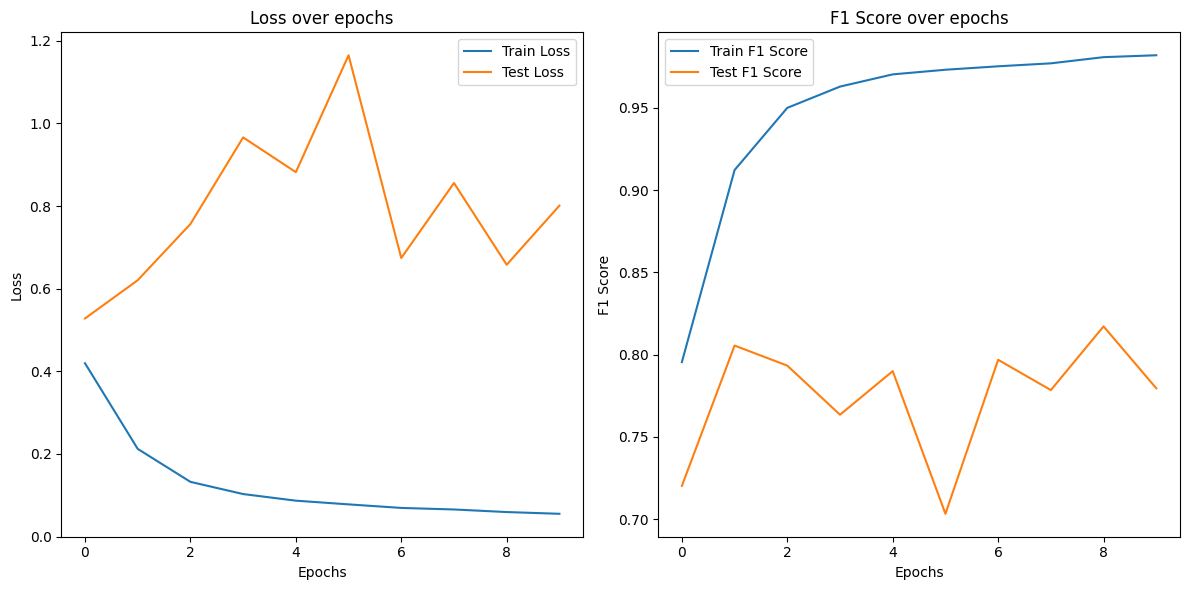

In [25]:
# Plotting the metrics
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(loss_train, label='Train Loss')
plt.plot(loss_test, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(f1_train, label='Train F1 Score')
plt.plot(f1_test, label='Test F1 Score')
plt.title('F1 Score over epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
torch.save(model.state_dict(), 'CNN_2.pth')

# 4. Evaluation Model

In [28]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns


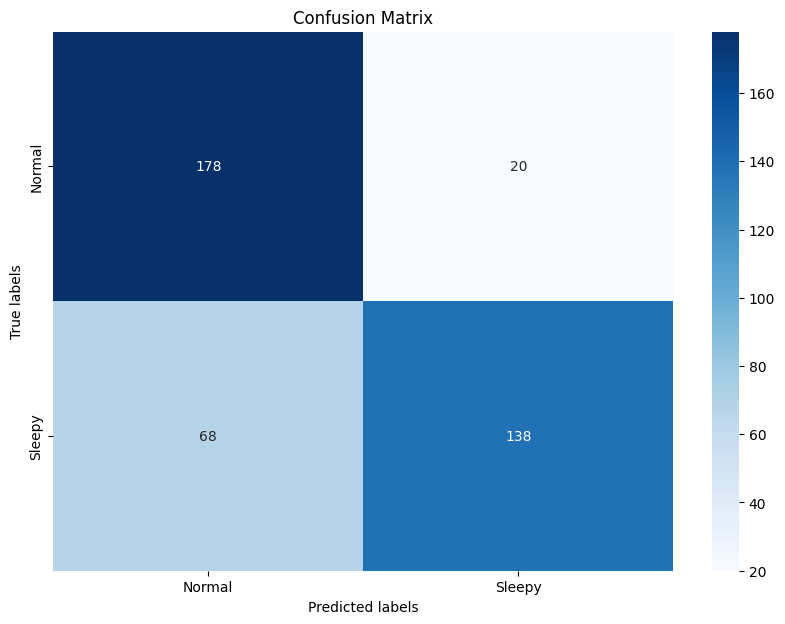

In [29]:
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for data in TESTLOADER:
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().tolist())
        all_true_labels.extend(labels.cpu().tolist())


# Compute confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes_name, yticklabels=classes_name)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

f1 = f1_score(all_true_labels, all_predictions, average='weighted')
print("Weighted F1 Score:", f1)

In [30]:
print(classification_report(all_true_labels, all_predictions, target_names=classes_name))

              precision    recall  f1-score   support

      Normal       0.72      0.90      0.80       198
      Sleepy       0.87      0.67      0.76       206

    accuracy                           0.78       404
   macro avg       0.80      0.78      0.78       404
weighted avg       0.80      0.78      0.78       404

